In [1]:
# IMPORT
%matplotlib inline
import csv
import os
import time
from operator import itemgetter, attrgetter, methodcaller
from skimage.filters import threshold_otsu, threshold_adaptive, rank
from skimage.morphology import disk
from skimage.feature import match_template
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
# Imports the Google Cloud client library
from google.cloud import storage
# Pandas is used for data manipulation
import pandas as pd

In [2]:
# READ crops
crops = {}
with open('crops.csv') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=("file","x_start","y_start","x_end","y_end","rotate","horiz","upside"))
    next(reader)
    for row in reader:
        row['name'] = row['file'].split("/")[5] # stay with the folder name
        row['name'] = row['name'].split("-")
        row['name'] = row['name'][0] + row['name'][1] # set the short name...
        row['x_start'] = int(row['x_start'])
        row['y_start'] = int(row['y_start'])
        row['x_end'] = int(row['x_end'])
        row['y_end'] = int(row['y_end'])
        # import pdb; pdb.set_trace()
        row['rotate'] = True if row['rotate'] == 'True' else False
        crops[row['name']] = row


In [11]:
# UTILITY func
cube_size = 250
HORIZ_TOLERANCE_FACTOR = 50
VERT_TOLERANCE_FACTOR = 75
EDGE_GAP = 50
bucket_name = "thesis-papyri"
imgs_root = "PAPYRI/" # "/Volumes/250GB/PAPYRI/"
cropped_root = "/cropped2/" # "/Volumes/250gb/cropped2"
matched_root = "/matched593/" # "/Volumes/250gb/cropped2"
#local_temp_root = "/home/il239838/files/temp/"
local_temp_root = "/Users/il239838/Downloads/temp/"

# Instantiates a client
# storage_client = storage.Client()

def list_blobs_with_prefix(storage_client, prefix):
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter='/')

    for blob in blobs:
        if blob.name[-1] != '/':
            yield blob.name
        
    #     if delimiter:
    #         print('Prefixes:')
    #         for prefix in blobs.prefixes:
    #             print(prefix)

def download_blob(storage_client, source_blob_name, destination_file_name):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    # print('Blob {} downloaded to {}.'.format(
    #    source_blob_name,
    #    destination_file_name))

def gcp_img_read(storage_client, chunk, img_path):
    # import pdb; pdb.set_trace()
    fname = img_path[img_path.rfind("/") + 1:]
    download_blob(storage_client, img_path, local_temp_root + str(chunk) + fname)
    time.sleep(2)
    result = img.imread(local_temp_root + str(chunk) + fname)
    time.sleep(1)
    os.remove(local_temp_root + str(chunk) + fname)
    return result

def gcp_np_load(storage_client, img_path):
    # import pdb; pdb.set_trace()
    fname = img_path[img_path.rfind("/") + 1:]
    download_blob(storage_client, img_path, local_temp_root + fname)
    time.sleep(2)
    result = np.load(local_temp_root + fname)
    os.remove(local_temp_root + fname)
    time.sleep(1)
    return result
    
# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]


def calc_combined_coordinates(base_x, base_y, offset_x, offset_y, base_rotate, base_x_end):
    if base_rotate:
        result_x = base_x_end - cube_size - offset_y # 250==CUBE_SIZE
        result_y = base_y + offset_x
    else:
        result_x = base_x + offset_x
        result_y = base_y + offset_y
    return result_x, result_y


# imgs_root = "/Volumes/250GB/PAPYRI/"
# cropped_root = "/Volumes/250gb/cropped2"

def load_img_for_name(storage_client, chunk, file_name):
    img_path = ""
    if "-" in file_name:
        name_parts = file_name.split("-")
        unique_part = name_parts[0] + "-" + name_parts[1] + "-" + name_parts[2]
        img_path = imgs_root + name_parts[0] + "/" + \
            unique_part + "/"
    else:
        img_path = imgs_root + file_name[0:4] + "/" + \
            file_name[0:4] + "-" + file_name[4:9] + "-V/"
    
    for file_ in list_blobs_with_prefix(storage_client, img_path):
        if (" _018" in file_):        
            return gcp_img_read(storage_client, chunk, file_) # img.imread(img_path + file_)

def load_cropped_for_name(file_name):
    img_path = cropped_root + "/" + file_name + " _018.jpg.npy"
    return np.load(img_path)

def load_cropped_for_name(file_name):
    img_path = cropped_root + "/" + file_name + " _018.jpg.npy"
    return gcp_np_load(img_path) # np.load(img_path)

def load_front_for_name(storage_client, chunk, file_name):
    img_path = ""
    if "-" in file_name:
        front_file_name = file_name.replace("-V-","-R-")
        name_parts = front_file_name.split("-")
        unique_part = name_parts[0] + "-" + name_parts[1] + "-" + name_parts[2]
        img_path = imgs_root + name_parts[0] + "/" + \
            unique_part + "/"
    else:
        img_path = imgs_root + file_name[0:4] + "/" + \
            file_name[0:4] + "-" + file_name[4:9] + "-R/"
    #import pdb; pdb.set_trace()
    #for root, dirs, files in os.walk(img_path):
    for file_ in list_blobs_with_prefix(storage_client, img_path):
        if (" _018" in file_):        
            return gcp_img_read(storage_client, chunk, file_) # img.imread(img_path + file_)
    
# Pre-process the validation set
def folder_walker(storage_client, path, full_path, filter_text=""):
    result = []
    #for root, dirs, files in os.walk(img_path):
    for file_ in list_blobs_with_prefix(storage_client, path):
        if "-V-" in file_ and not file_.startswith("."):
            if (filter_text == "" or filter_text in file_):
                result.append(file_)
    return result

# no_rotate = folder_walker(storage.Client(), "no_rotate/", False)

    

In [ ]:
# CALC basic voting metrics per fragment and per side ALSO accumulate matches per fragment for trend (later)
count = 0
fragmentTotal = {} # Total number of fragments: usually indication of the size of the fragment
fragmentVote = {} # basic fragment voting: one fragment vote per one match regardless of the side of the fragment
fragmentAndSideTotal = {} # Total number of fragments per side: usually indication of the size of the side
fragmentAndSideVote = {} # basic fragment-side voting: one fragment-side vote per one match on the specific side
fragmentAndSideTrend = {}
fragmentAndSideCubes = {}
fragmentAndSideClass = {}
origCoordinates = {}
fragmentNames = {}
matchFirstFile = {}
matchSecondFile = {}
firstNames = {}
secondNames = {}
fragmentAndSideDrawRect = {}
fragmentAndSideMatchPoint = {}

with open('20181020_212330_pairs_all_matches.csv') as csvfile:
    # reader = csv.DictReader(csvfile, fieldnames=("firstName","secondName","gap"))
    reader = csv.DictReader(csvfile, fieldnames=("firstName","secondName","totalFragment","totalSide"))
    for row in reader:
        row['secondName'] = row['secondName'].split(".")[0] # get rid of the suffix

        # split the first file name and calc the row and col
        split = row['firstName'].split("_")
        row['firstNameOrig'] = split[0]
        row['firstRow'] = int(int(split[1]) / 250)
        row['firstY'] = int(split[1])
        row['firstX'] = int(split[2])
        row['firstCol'] = 0 if row['firstX'] < 100 else 1
        split = row['firstNameOrig'].split("-")
        row['firstName'] = split[0] + split[1]

        # split the second file name and calc the row and col
        split = row['secondName'].split("_")
        row['secondNameOrig'] = split[0]
        row['secondRow'] = int(int(split[1]) / 250)
        row['secondY'] = int(split[1])
        row['secondX'] = int(split[2])
        row['secondCol'] = 0 if row['secondX'] < 100 else 1
        split = row['secondNameOrig'].split("-")
        row['secondName'] = split[0] + split[1]

        row['matchFragmentKey'] = row['firstName'] + "_" + row['secondName']
        if row['matchFragmentKey'] not in fragmentTotal:
            fragmentTotal[row['matchFragmentKey']] = 0
            fragmentVote[row['matchFragmentKey']] = 0

        fragmentVote[row['matchFragmentKey']] += 1
        fragmentTotal[row['matchFragmentKey']] = \
            int(row['totalFragment']) if int(row['totalFragment']) > fragmentTotal[row['matchFragmentKey']] else fragmentTotal[row['matchFragmentKey']]

        row['matchFragmentAndSideKey'] = row['firstName'] + "_" + str(row['firstCol']) \
            + "_" + row['secondName'] + "_" + str(row['secondCol'])
        if row['matchFragmentAndSideKey'] not in fragmentAndSideVote:
            fragmentAndSideClass[row['matchFragmentAndSideKey']] = 0
            fragmentAndSideTotal[row['matchFragmentAndSideKey']] = 0
            fragmentAndSideVote[row['matchFragmentAndSideKey']] = 0
            fragmentAndSideTrend[row['matchFragmentAndSideKey']] = []
            fragmentAndSideCubes[row['matchFragmentAndSideKey']] = []
            origCoordinates[row['matchFragmentAndSideKey']] = []
            fragmentNames[row['matchFragmentAndSideKey']] = row['matchFragmentKey']
            firstNames[row['matchFragmentAndSideKey']] = row['firstName']
            secondNames[row['matchFragmentAndSideKey']] = row['secondName']
            fragmentAndSideDrawRect[row['matchFragmentAndSideKey']] = []
            fragmentAndSideMatchPoint[row['matchFragmentAndSideKey']] = []
            
        fragmentAndSideTotal[row['matchFragmentAndSideKey']] = \
            int(row['totalSide']) if int(row['totalSide']) > fragmentAndSideTotal[row['matchFragmentAndSideKey']] else fragmentAndSideTotal[row['matchFragmentAndSideKey']]
            fragmentAndSideVote[row['matchFragmentAndSideKey']] += 1

        invert = True if row['firstCol'] == row['secondCol'] else False
        fragmentAndSideTrend[row['matchFragmentAndSideKey']].append([invert, row['firstRow'], row['secondRow']])
        fragmentAndSideCubes[row['matchFragmentAndSideKey']].append([row['firstX'], row['firstY'], row['secondX'], row['secondY']])

        # TODO: FIXME:
        # probably need to fix the next line since we moved to real matches to be able to handle flips - the x/y would not match
        fragmentAndSideDrawRect[row['matchFragmentAndSideKey']].append([row['firstX'] + cube_size + EDGE_GAP - HORIZ_TOLERANCE_FACTOR, 
                                                                        row['firstY'] - row['secondY'] - VERT_TOLERANCE_FACTOR,
                                                                        row['firstX'] + cube_size + EDGE_GAP + HORIZ_TOLERANCE_FACTOR, 
                                                                        row['firstY'] - row['secondY'] + VERT_TOLERANCE_FACTOR])
        fragmentAndSideMatchPoint[row['matchFragmentAndSideKey']].append([row['firstX'] + cube_size + EDGE_GAP, 
                                                                          row['firstY'] - row['secondY']])

        
#         firstCrop = crops[row['firstName']]
#         firstXcombined, firstYCombined = \
#             calc_combined_coordinates(firstCrop['x_start'], firstCrop['y_start'], row['firstX'], row['firstY'], firstCrop['rotate'], firstCrop['x_end'])
#         secondCrop = crops[row['secondName']]
#         secondXcombined, secondYCombined = \
#             calc_combined_coordinates(secondCrop['x_start'], secondCrop['y_start'], row['secondX'], row['secondY'], secondCrop['rotate'], secondCrop['x_end'])
#         origCoordinates[row['matchFragmentAndSideKey']].append([firstXcombined, firstYCombined, secondXcombined, secondYCombined])
#         matchFirstFile[row['matchFragmentAndSideKey']] = row['firstNameOrig']
#         matchSecondFile[row['matchFragmentAndSideKey']] = row['secondNameOrig']

#         # print(row['firstName'], row['firstRow'], row['firstCol'], row['secondName'], row['secondRow'], row['secondCol'], row['gap'])
#         count += 1

In [ ]:
# CALC simple trend voting
fragmentAndSideTrendVote = {}
for fragmanetAndSideKey in fragmentAndSideTrend:
    # import pdb; pdb.set_trace()
    fragmentAndSideTrend[fragmanetAndSideKey] = sorted(fragmentAndSideTrend[fragmanetAndSideKey], key=itemgetter(2), reverse=fragmentAndSideTrend[fragmanetAndSideKey][0][0])
    fragmentAndSideTrend[fragmanetAndSideKey] = sorted(fragmentAndSideTrend[fragmanetAndSideKey], key=itemgetter(1))
    firstPrev = 0
    secondPrev = 0
    trend = 0
    for match in fragmentAndSideTrend[fragmanetAndSideKey]:
        if (match[1] - firstPrev) <= 1:
            if match[0] and (secondPrev == 0 or (secondPrev - match[2]) <= 1): # match[0] == inverted
                trend += 1
            elif (match[2] - secondPrev) <= 1:
                trend += 1
        firstPrev = match[1]
        secondPrev = match[2]
    fragmentAndSideTrendVote[fragmanetAndSideKey] = trend

In [ ]:
# CALC strict trend voting PLUS bonus for synchronized trend ALSO calc bonus separately
fragmentAndSideTrendVoteStrict = {}
fragmentAndSideTrendVoteSync = {}
for fragmanetAndSideKey in fragmentAndSideTrend:
    # import pdb; pdb.set_trace()
    fragmentAndSideTrend[fragmanetAndSideKey] = sorted(fragmentAndSideTrend[fragmanetAndSideKey], key=itemgetter(2), reverse=fragmentAndSideTrend[fragmanetAndSideKey][0][0])
    fragmentAndSideTrend[fragmanetAndSideKey] = sorted(fragmentAndSideTrend[fragmanetAndSideKey], key=itemgetter(1))
    firstPrev = -1
    secondPrev = -1
    trend = 0
    sync = 0
    maxTrend = 0
    for match in fragmentAndSideTrend[fragmanetAndSideKey]:
        if firstPrev != -1:
            if (match[1] - firstPrev) == 0:
                if match[0] and (secondPrev - match[2]) == 1: # match[0] == inverted
                    trend += 1
                elif (match[2] - secondPrev) == 1:
                    trend += 1
                else:
                    trend = 0
            elif (match[1] - firstPrev) == 1:
                if match[0] and (secondPrev - match[2]) == 1: # match[0] == inverted
                    trend += 2
                    sync += 1
                elif match[0] and (secondPrev - match[2]) == 0: # match[0] == inverted
                    trend += 1
                elif (match[2] - secondPrev) == 1:
                    trend += 2
                    sync += 1
                elif (match[2] - secondPrev) == 0:
                    trend += 1
                else:
                    trend = 0
        maxTrend = max(trend, maxTrend)
        firstPrev = match[1]
        secondPrev = match[2]
    fragmentAndSideTrendVoteStrict[fragmanetAndSideKey] = maxTrend
    fragmentAndSideTrendVoteSync[fragmanetAndSideKey] = sync

In [ ]:
# WRITE results to a CSV file
with open('20181020_212330_pairs_votes.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(["fragmanetAndSide", 
                        "fragment", 
                        "fragmentTotal",
                        "fragmentVote",
                        "devideVoteByTotal",
                        "fragmentAndSideTotal",
                        "fragmentAndSideVote",
                        "devideSideVoteBySideTotal",
                        "fragmentAndSideTrendVote",
                        "devideSideTrendVoteBySideTotal",
                        "fragmentAndSideTrendVoteStrict",
                        "devideSideTrendVoteStrictBySideTotal",
                        "fragmentAndSideTrendVoteSync",
                        "devideSideTrendVoteSyncBySideTotal",

                        "firstFileName",
                        "firstCroppedWidth",
                        "firstOffsetX",
                        "firstOffsetY",
                        "firstHorizontalFlip",
                        "secondFileName",
                        "secondCroppedWidth",
                        "secondOffsetX",
                        "secondOffsetY",
                        "secondHorizontalFlip",                        
                        
                        "fragmentAndSideTrend",
                        "fragmentAndSideCubes",
                        "fragmentAndSideDrawRect",
                        "fragmentAndSideMatchPoint",
                        "origCoordinates",
                        "class"
                       ])
    for fragmanetAndSideKey in fragmentAndSideVote:
        csvwriter.writerow([fragmanetAndSideKey, 
                            fragmentNames[fragmanetAndSideKey], 
                            fragmentTotal[fragmentNames[fragmanetAndSideKey]],
                            fragmentVote[fragmentNames[fragmanetAndSideKey]],
                            fragmentVote[fragmentNames[fragmanetAndSideKey]] / fragmentTotal[fragmentNames[fragmanetAndSideKey]],
                            fragmentAndSideTotal[fragmanetAndSideKey],
                            fragmentAndSideVote[fragmanetAndSideKey],
                            fragmentAndSideVote[fragmanetAndSideKey] / fragmentAndSideTotal[fragmanetAndSideKey],
                            fragmentAndSideTrendVote[fragmanetAndSideKey],
                            fragmentAndSideTrendVote[fragmanetAndSideKey] / fragmentAndSideTotal[fragmanetAndSideKey],
                            fragmentAndSideTrendVoteStrict[fragmanetAndSideKey],
                            fragmentAndSideTrendVoteStrict[fragmanetAndSideKey] / fragmentAndSideTotal[fragmanetAndSideKey],
                            fragmentAndSideTrendVoteSync[fragmanetAndSideKey],
                            fragmentAndSideTrendVoteSync[fragmanetAndSideKey] / fragmentAndSideTotal[fragmanetAndSideKey],
                            
                            firstNames[fragmanetAndSideKey],
                            0,
                            0,
                            0,
                            0,
                            secondNames[fragmanetAndSideKey],
                            0,
                            0,
                            0,
                            0,
                            
                            fragmentAndSideTrend[fragmanetAndSideKey],
                            fragmentAndSideCubes[fragmanetAndSideKey],
                            fragmentAndSideDrawRect[fragmanetAndSideKey],
                            fragmentAndSideMatchPoint[fragmanetAndSideKey],
                            origCoordinates[fragmanetAndSideKey],
                            fragmentAndSideClass[fragmanetAndSideKey]
                           ])
    

In [4]:
# STOP HERE? NO!! Need the next 2 cells for the alignment of the flipped image

In [5]:
# UTIL 2 - needed functions for flipping and matching
def find_match(big_img, small_img):
    match_map = match_template(big_img, small_img)
    offsets_arr = np.unravel_index(np.argmax(match_map), match_map.shape)
    offset_x, offset_y = offsets_arr[::-1]        
    return offset_x, offset_y, match_map[offsets_arr]
  

def extract_image_derivatives(storage_client, chunk, file_name):
    import pdb; pdb.set_trace()
    image = load_img_for_name(storage_client, chunk, file_name)
    short_name = file_name
    img_crop = crops[short_name]
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    front = load_front_for_name(storage_client, chunk, file_name)
    front_adaptive = threshold_adaptive(front, 251, offset=5)  
    # import pdb; pdb.set_trace()
    cropped_adaptive = threshold_adaptive(cropped, 251, offset=5)
    cropped_flipped_lr = cropped_adaptive[:,::-1]
    offset_x_lr, offset_y_lr, val_lr = find_match(front_adaptive, cropped_flipped_lr)
    cropped_flipped_ud = cropped_adaptive[::-1]
    offset_x_ud, offset_y_ud, val_ud = find_match(front_adaptive, cropped_flipped_ud)

    if (val_lr >= val_ud):
        return cropped_flipped_lr.shape[1], offset_x_lr, offset_y_lr, True
    else:
        return cropped_flipped_ud.shape[1], offset_x_ud, offset_y_ud, False
    

def extract_image_derivatives_orig(file_name):
    image = load_img_for_name(file_name)
    split = file_name.split("-")
    short_name = split[0] + split[1]
    img_crop = crops[short_name]
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    front = load_front_for_name(file_name)
    front_adaptive = threshold_adaptive(front, 251, offset=5)  
    # import pdb; pdb.set_trace()
    cropped_adaptive = threshold_adaptive(cropped, 251, offset=5)
    cropped_flipped_lr = cropped_adaptive[:,::-1]
    offset_x_lr, offset_y_lr, val_lr = find_match(front_adaptive, cropped_flipped_lr)
    cropped_flipped_ud = cropped_adaptive[:,::-1]
    offset_x_ud, offset_y_ud, val_ud = find_match(front_adaptive, cropped_flipped_ud)

    if (val_lr >= val_ud):
        return front, cropped_flipped_lr, offset_x_lr, offset_y_lr
    else:
        return front, cropped_flipped_ud, offset_x_ud, offset_y_ud
    
    

x1start = 0
y1start = 0


def get_cube_coordinates(file_name, cropped_width, offset_x, offset_y, cubex, cubey):
    if file_name[0:file_name.rfind('-D')] not in no_rotate:
        temp = cubex
        cubex = cropped_width - cubey - cube_size
        cubey = temp

    reverse_cubex = x1start + offset_x + cube_size + (cropped_width - cubex - cube_size)
    reverse_cubey = y1start + offset_y + cube_size + cubey
    
    return reverse_cubex, reverse_cubey

In [6]:
# WRITE results for flip and match into a CSV file - WARNING - SLOW RUN!!! 
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores * 4

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)

    # test block for running serialy    
    # results = []
    # for item in zip(np.arange(num_partitions), df_split):
    #    results.append(func(item))
    # df = pd.concat(results, ignore_index=True)

    # parallel block
    pool = multiprocessing.Pool(num_cores)
    df = pd.concat(pool.map(func, zip(np.arange(num_partitions), df_split)))
    pool.close()
    pool.join()

    return df
    
def flip_row(storage_client, chunk, df, idx, df_row):
    # import pdb; pdb.set_trace()
    first_file_name = df_row["firstFileName"]
    second_file_name = df_row["secondFileName"]
    print("Process chunk:" + str(chunk) + " IDX:" + str(idx) + " File1:" + first_file_name + " File2:", second_file_name)

    first_cropped_width, first_offset_x, first_offset_y, first_is_horiz = \
        extract_image_derivatives(storage_client, chunk, first_file_name)
    second_cropped_width, second_offset_x, second_offset_y, second_is_horiz = \
        extract_image_derivatives(storage_client, chunk, second_file_name)

    df.at[idx, "firstCroppedWidth"] = first_cropped_width
    df.at[idx, "firstOffsetX"] = first_offset_x
    df.at[idx, "firstOffsetY"] = first_offset_y
    df.at[idx, "firstHorizontalFlip"] = 1 if first_is_horiz else 0

    df.at[idx, "secondCroppedWidth"] = second_cropped_width
    df.at[idx, "secondOffsetX"] = second_offset_x
    df.at[idx, "secondOffsetY"] = second_offset_y
    df.at[idx, "secondHorizontalFlip"] = 1 if second_is_horiz else 0

def flip_df(args):
    iter_count = args[0]
    split_df = args[1]
    print("Chunk", iter_count, " LEN SPLIT:", len(split_df.index))
    # print("Chunk", iter_count)
    storage_client = storage.Client()
    for idx, row in split_df.iterrows():
        flip_row(storage_client, iter_count, split_df, idx, row)
    return split_df

all_matches = pd.read_csv('20181020_212330_pairs_final.csv')
print("LEN:",len(all_matches.index))
flipped_matches = parallelize_dataframe(all_matches, flip_df)
# import pdb; pdb.set_trace()
print("LEN FLIP:",len(flipped_matches.index))
flipped_matches.to_csv('20181020_212330_pairs_final_flipped.csv')    

LEN: 252
Chunk 1  LEN SPLIT: 8
Chunk 0  LEN SPLIT: 8
Chunk 3  LEN SPLIT: 8
Chunk 2  LEN SPLIT: 8
Chunk 5  LEN SPLIT: 8
Process chunk:1 IDX:8 File1:P593Fg004 File2: P593Fg019
Chunk 6  LEN SPLIT: 8
Chunk 4  LEN SPLIT: 8
Process chunk:3 IDX:24 File1:P593Fg003 File2: P593Fg013
Process chunk:0 IDX:0 File1:P593Fg008 File2: P593Fg013
Process chunk:5 IDX:40 File1:P593Fg013 File2: P593Fg019
Process chunk:2 IDX:16 File1:P593Fg016 File2: P593Fg017
Process chunk:4 IDX:32 File1:P593Fg004 File2: P593Fg018
Process chunk:6 IDX:48 File1:P593Fg015 File2: P593Fg017
Chunk 7  LEN SPLIT: 8
Process chunk:7 IDX:56 File1:P593Fg002 File2: P593Fg018


/home/il239838/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/il239838/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
/home/il239838/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_resul

Process chunk:0 IDX:1 File1:P593Fg011 File2: P593Fg016
Process chunk:2 IDX:17 File1:P593Fg013 File2: P593Fg014
Process chunk:1 IDX:9 File1:P593Fg001 File2: P593Fg019
Process chunk:5 IDX:41 File1:P593Fg009 File2: P593Fg014
Process chunk:4 IDX:33 File1:P593Fg003 File2: P593Fg018
Process chunk:6 IDX:49 File1:P593Fg001 File2: P593Fg002
Process chunk:7 IDX:57 File1:P593Fg002 File2: P593Fg004
Process chunk:3 IDX:25 File1:P593Fg009 File2: P593Fg015
Process chunk:5 IDX:42 File1:P593Fg012 File2: P593Fg016
Process chunk:2 IDX:18 File1:P593Fg002 File2: P593Fg017
Process chunk:0 IDX:2 File1:P593Fg001 File2: P593Fg010
Process chunk:7 IDX:58 File1:P593Fg001 File2: P593Fg016
Process chunk:3 IDX:26 File1:P593Fg017 File2: P593Fg018
Process chunk:4 IDX:34 File1:P593Fg004 File2: P593Fg010
Process chunk:1 IDX:10 File1:P593Fg001 File2: P593Fg003
Process chunk:6 IDX:50 File1:P593Fg013 File2: P593Fg015
Process chunk:5 IDX:43 File1:P593Fg001 File2: P593Fg005
Process chunk:2 IDX:19 File1:P593Fg001 File2: P593F

In [ ]:
# STOP!!! Obselete!!! WRITE results to a CSV file
with open('cubes_X3_e.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(["fragmanetAndSide", 
                        "fragment", 
                        "fragmentVote",
                        "fragmentAndSideVote",
                        "fragmentAndSideTrendVote",
                        "fragmentAndSideTrendVoteStrict",
                        "fragmentAndSideTrendVoteSync",
                        "firstFileName",
                        "firstCroppedWidth",
                        "firstOffsetX",
                        "firstOffsetY",
                        "firstHorizontalFlip",
                        "secondFileName",
                        "secondCroppedWidth",
                        "secondOffsetX",
                        "secondOffsetY",
                        "secondHorizontalFlip",
                        "fragmentAndSideTrend",
                        "fragmentAndSideCubes",
                        "origCoordinates"])
    for fragmanetAndSideKey in fragmentAndSideVote:
        if fragmentAndSideTrendVoteSync[fragmanetAndSideKey] > 0:
            print(fragmanetAndSideKey)

            first_file_name = matchFirstFile[fragmanetAndSideKey]
            first_cropped_width, first_offset_x, first_offset_y, first_is_horiz = \
                extract_image_derivatives(first_file_name)
            second_file_name = matchSecondFile[fragmanetAndSideKey]
            second_cropped_width, second_offset_x, second_offset_y, second_is_horiz = \
                extract_image_derivatives(second_file_name)

            csvwriter.writerow([fragmanetAndSideKey, 
                                fragmentNames[fragmanetAndSideKey], 
                                fragmentVote[fragmentNames[fragmanetAndSideKey]],
                                fragmentAndSideVote[fragmanetAndSideKey],
                                fragmentAndSideTrendVote[fragmanetAndSideKey],
                                fragmentAndSideTrendVoteStrict[fragmanetAndSideKey],
                                fragmentAndSideTrendVoteSync[fragmanetAndSideKey],
                                first_file_name,
                                first_cropped_width,
                                first_offset_x, 
                                first_offset_y,
                                first_is_horiz,
                                second_file_name,
                                second_cropped_width,
                                second_offset_x, 
                                second_offset_y, 
                                second_is_horiz,
                                fragmentAndSideTrend[fragmanetAndSideKey],
                                fragmentAndSideCubes[fragmanetAndSideKey],
                                origCoordinates[fragmanetAndSideKey]])

P589Fg007_1_P598Fg035_1
P589Fg007_1_P598Fg035_1


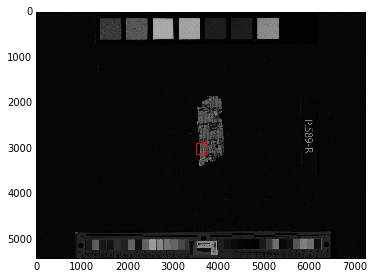

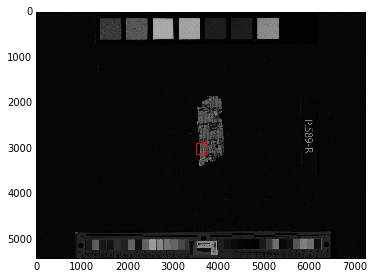

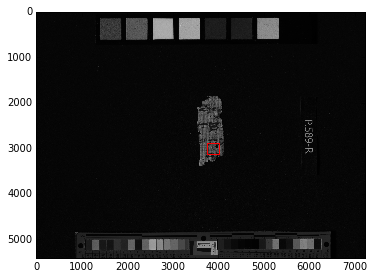

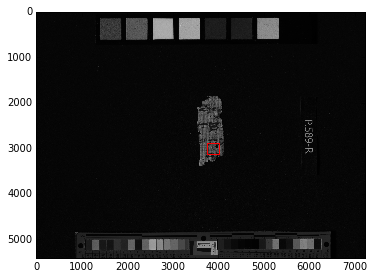

In [49]:
# DEBUG - don't run

done = False
for fragmanetAndSideKey in fragmentAndSideVote:
    if fragmentAndSideTrendVoteSync[fragmanetAndSideKey] > 0 and not done:
        # import pdb; pdb.set_trace()
        file_name = matchFirstFile[fragmanetAndSideKey]
        print(fragmanetAndSideKey)
        print(file_name)
        cropped_width, offset_x, offset_y = extract_image_derivatives(file_name)
        done = True
        front = load_front_for_name(file_name)
        for cube_match in fragmentAndSideCubes[fragmanetAndSideKey]:
            x_co, y_co = get_cube_coordinates(file_name, cropped_width, offset_x, offset_y, cube_match[0], cube_match[1])
            fig = plt.figure(figsize=(20, 6))
            ax2 = plt.subplot(1, 3, 1, adjustable='box-forced')
            ax2.imshow(front, cmap=plt.cm.gray)
            rect = plt.Rectangle((x_co, y_co), cube_size, cube_size, edgecolor='r', facecolor='none')
            ax2.add_patch(rect)
            plt.show()

In [ ]:
# DEBUG - don't run
for cube_match in fragmentAndSideCubes[fragmanetAndSideKey]:
    draw_on_plot(plt, ax2, flipped, offset_x, offset_y, cube_match[0], cube_match[1])
